In [ ]:
!pip install transformers datasets evaluate seqeval

import os
import json
import numpy as np
from datasets import load_dataset
import evaluate
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, Trainer, TrainingArguments


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=b2af7803dff247ba1bfbb3ac3456cdac519cd6e325c11145672ef1778f0b247f
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.

In [ ]:
model_checkpoint = "google/mobilebert-uncased"
num_epochs = 20
batch_size = 32
learning_rate = 0.0005

# Define your labels
entity_labels = ["HOSP", "PATIENT", "STAFF", "AGE", "DATE", "PHONE", "ID", "EMAIL", "LOC", "PATORG"]
all_labels = ["O"] + entity_labels
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

print("Labels:", all_labels)


Labels: ['O', 'HOSP', 'PATIENT', 'STAFF', 'AGE', 'DATE', 'PHONE', 'ID', 'EMAIL', 'LOC', 'PATORG']


In [ ]:

# Load dataset (adapt paths as needed)
data_files = {
    "train": "train.json",
    "validation": "validation.json"
}
raw_dataset = load_dataset("json", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)


In [ ]:

def align_spans_to_tokens(examples):
    texts = examples["text"]
    batch_tokenized = tokenizer(
        texts,
        truncation=True,
        return_offsets_mapping=True
    )

    new_labels = []
    for i, offsets in enumerate(batch_tokenized["offset_mapping"]):
        spans = examples["spans"][i]
        span_entities = [(s["start"], s["end"], s["label"]) for s in spans]

        token_labels = ["O"] * len(offsets)

        for span_start, span_end, span_label in span_entities:
            for idx, (token_start, token_end) in enumerate(offsets):
                if token_start == 0 and token_end == 0:
                    continue
                if token_end > span_start and token_start < span_end:
                    token_labels[idx] = span_label

        label_ids = [label2id[label] for label in token_labels]
        new_labels.append(label_ids)

    batch_tokenized["labels"] = new_labels
    batch_tokenized.pop("offset_mapping")
    return batch_tokenized


In [ ]:
encoded_dataset = raw_dataset.map(
    align_spans_to_tokens,
    batched=True,
    remove_columns=raw_dataset["train"].column_names
)

Map:   0%|          | 0/673 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/95 [00:00<?, ? examples/s]

In [ ]:

train_dataset = encoded_dataset["train"]
eval_dataset = encoded_dataset["validation"]


In [ ]:

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(all_labels),
    id2label=id2label,
    label2id=label2id
)

Some weights of MobileBertForTokenClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("device:", device)


device: cuda


In [ ]:

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Use the new evaluate library
metric = evaluate.load("seqeval")


In [ ]:

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_predictions = []

    for label_ids, pred_ids in zip(labels, predictions):
        # Only consider non-padding tokens (where label_ids != tokenizer.pad_token_id)
        # If you used -100 for ignored tokens, check that instead (e.g. if l != -100)
        filtered_labels = []
        filtered_preds = []
        for l, p_ in zip(label_ids, pred_ids):
          if l != -100:
              filtered_labels.append(id2label[l])
              filtered_preds.append(id2label[p_])

        true_labels.append(filtered_labels)
        true_predictions.append(filtered_preds)

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
print("DONE")

DONE


In [ ]:
training_args = TrainingArguments(
    output_dir="./mobilebert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
metrics = trainer.evaluate()
print("Evaluation:", metrics)

trainer.save_model("final_model")
tokenizer.save_pretrained("final_model")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-26-ad0317562906>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.215812,0.726644,0.855397,0.785781,0.931245
2,No log,0.098430,0.828780,0.926680,0.875000,0.966387
3,No log,0.143158,0.817690,0.922607,0.866986,0.961421
4,No log,0.064108,0.868030,0.951120,0.907677,0.975554
5,No log,0.082384,0.857671,0.945010,0.899225,0.970588
6,No log,0.076073,0.871212,0.936864,0.902846,0.975554
7,No log,0.090068,0.868173,0.938900,0.902153,0.974026
8,No log,0.120107,0.833333,0.936864,0.882071,0.967532
9,No log,0.113857,0.859519,0.947047,0.901163,0.972880
10,No log,0.209722,0.828520,0.934827,0.878469,0.962949


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: HOSP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PATIENT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: STAFF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: DATE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AGE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: HOSP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PATIENT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: STAFF seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: DATE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: AGE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:

Evaluation: {'eval_loss': 0.035327620804309845, 'eval_precision': 0.9737903225806451, 'eval_recall': 0.9837067209775967, 'eval_f1': 0.978723404255319, 'eval_accuracy': 0.9935064935064936, 'eval_runtime': 0.226, 'eval_samples_per_second': 420.295, 'eval_steps_per_second': 13.272, 'epoch': 20.0}


('final_model/tokenizer_config.json',
 'final_model/special_tokens_map.json',
 'final_model/vocab.txt',
 'final_model/added_tokens.json',
 'final_model/tokenizer.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Adjust these paths as necessary
model_path = "final_model"  # folder where your model was saved

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
model = AutoModelForTokenClassification.from_pretrained(model_path)

# If you have GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Suppose these were defined previously in your training script
# If not, load from config or define again:
# Example:
id2label = model.config.id2label
# id2label is a dictionary like {0: "O", 1: "HOSP", 2: "PATIENT", ...}

# Input sentence
sentence = """               BLOOD TEST REPORT

Patient Details:
Name:           John Doe
Age:            45 years
Gender:         Male
Patient ID:     123456789
DOB:            January 1, 1978
Test Date:      December 7, 2024

Consulting Physician: Dr. Jane Smith
Lab Technician:      Emily White

TEST RESULTS

Complete Blood Count (CBC)
- White Blood Cells (WBC):           6.1 K/uL   (Normal: 4.5-11.0 K/uL)
- Red Blood Cells (RBC):             4.85 M/uL  (Normal: 4.7-6.1 M/uL)
- Hemoglobin (Hgb):                  13.8 g/dL  (Normal: 13.8-17.2 g/dL)
- Hematocrit (Hct):                  41.8%      (Normal: 40.7-50.3%)
- Platelets:                         298 K/uL   (Normal: 150-450 K/uL)

Lipid Profile

- Total Cholesterol:                 188 mg/dL  (Desirable: <200 mg/dL)
- HDL (High-Density Lipoprotein):    60 mg/dL   (Normal: >40 mg/dL)
- LDL (Low-Density Lipoprotein):     110 mg/dL  (Optimal: <100 mg/dL)
- Triglycerides:                     140 mg/dL  (Normal: <150 mg/dL)

Liver Function Tests

- Alanine Aminotransferase (ALT):    29 U/L     (Normal: 7-56 U/L)
- Aspartate Aminotransferase (AST):  35 U/L     (Normal: 10-40 U/L)
- Alkaline Phosphatase (ALP):        90 U/L     (Normal: 40-129 U/L)
- Bilirubin, Total:                  1.2 mg/dL  (Normal: 0.1-1.2 mg/dL)
------------------------------------------------------
Comments:
All values are within the normal range. No abnormalities detected.

"""
# sentence = "Patient Thejan Weerasekara, a 45-year-old male, who has patient ID 12434, was admitted to Saint Mary's Hospital on September 15, 2023, with symptoms of chest pain and shortness of breath. His wife, Jane Doe, reported that the symptoms had started suddenly the night before. Medical history includes hypertension and type 2 diabetes. The attending cardiologist, Dr. Smith, prescribed a course of treatment including medication and lifestyle adjustments."

# Tokenize
inputs = tokenizer(sentence, return_tensors="pt", truncation=True, is_split_into_words=False)
# Move to GPU if available
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits

# Get predicted label IDs
predictions = torch.argmax(logits, dim=2).cpu().numpy()[0]

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].cpu().numpy()[0])

# Print token and predicted label
for token, pred_id in zip(tokens, predictions):
    label = id2label[pred_id]
    # Skip special tokens like [CLS], [SEP]
    if token not in [tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token]:
        print(f"{token}\t{label}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


blood	O
test	O
report	O
patient	O
details	O
:	O
name	O
:	O
john	PATIENT
doe	PATIENT
age	O
:	O
45	AGE
years	ID
gender	O
:	O
male	ID
patient	O
id	O
:	O
123	ID
##45	ID
##6	ID
##7	ID
##8	ID
##9	ID
do	O
##b	O
:	O
january	DATE
1	DATE
,	DATE
1978	DATE
test	O
date	O
:	O
december	DATE
7	DATE
,	DATE
202	DATE
##4	DATE
consulting	O
physician	O
:	O
dr	STAFF
.	STAFF
jane	STAFF
smith	STAFF
lab	O
technician	O
:	O
emily	STAFF
white	STAFF
test	O
results	O
complete	O
blood	O
count	O
(	O
cbc	O
)	O
-	O
white	O
blood	O
cells	O
(	O
wb	O
##c	O
)	O
:	O
6	O
.	O
1	O
k	O
/	O
ul	O
(	O
normal	O
:	O
4	O
.	O
5	O
-	O
11	O
.	O
0	O
k	O
/	O
ul	O
)	O
-	O
red	O
blood	O
cells	O
(	O
rb	O
##c	O
)	O
:	O
4	O
.	O
85	O
m	O
/	O
ul	O
(	O
normal	O
:	O
4	O
.	O
7	O
-	O
6	O
.	O
1	O
m	O
/	O
ul	O
)	O
-	O
hem	O
##og	O
##lo	O
##bin	O
(	O
h	O
##gb	O
)	O
:	O
13	O
.	O
8	O
g	O
/	O
dl	O
(	O
normal	O
:	O
13	O
.	O
8	O
-	O
17	O
.	O
2	O
g	O
/	O
dl	O
)	O
-	O
hem	O
##ato	O
##cr	O
##it	O
(	O
hc	O
##t	O
)	O
:	O
41	O
.	O
8	O
%	O
(	O
normal	O
:	O
40	O
.	

In [34]:
print(log_history)


[{'eval_loss': 0.215812087059021, 'eval_precision': 0.726643598615917, 'eval_recall': 0.8553971486761711, 'eval_f1': 0.7857811038353602, 'eval_accuracy': 0.9312452253628725, 'eval_runtime': 0.3639, 'eval_samples_per_second': 261.036, 'eval_steps_per_second': 8.243, 'epoch': 1.0, 'step': 22}, {'eval_loss': 0.0984300822019577, 'eval_precision': 0.8287795992714025, 'eval_recall': 0.9266802443991853, 'eval_f1': 0.875, 'eval_accuracy': 0.9663865546218487, 'eval_runtime': 0.214, 'eval_samples_per_second': 443.892, 'eval_steps_per_second': 14.018, 'epoch': 2.0, 'step': 44}, {'eval_loss': 0.14315782487392426, 'eval_precision': 0.8176895306859205, 'eval_recall': 0.9226069246435845, 'eval_f1': 0.8669856459330143, 'eval_accuracy': 0.9614209320091673, 'eval_runtime': 0.2057, 'eval_samples_per_second': 461.865, 'eval_steps_per_second': 14.585, 'epoch': 3.0, 'step': 66}, {'eval_loss': 0.0641077309846878, 'eval_precision': 0.8680297397769516, 'eval_recall': 0.9511201629327902, 'eval_f1': 0.9076773566

In [35]:
# Filter based on available keys
if 'train_loss' in log_df.columns:
    train_logs = log_df[log_df["epoch"].notnull() & log_df["train_loss"].notnull()]
else:
    print("Train loss key not found in log history.")

if 'eval_loss' in log_df.columns:
    eval_logs = log_df[log_df["epoch"].notnull() & log_df["eval_loss"].notnull()]
else:
    print("Evaluation loss key not found in log history.")


In [36]:
# Dynamically find available keys
print("Available keys in log history:", log_df.columns.tolist())


Available keys in log history: ['eval_loss', 'eval_precision', 'eval_recall', 'eval_f1', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step', 'train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss']


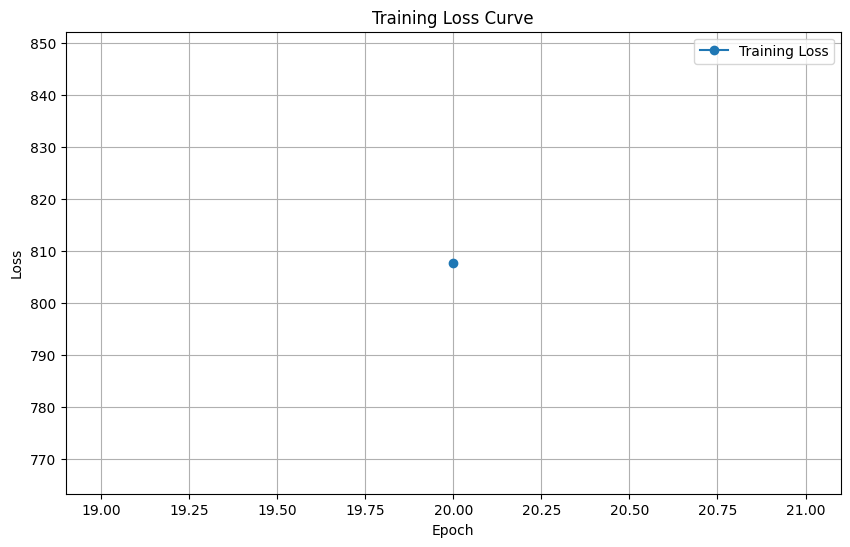

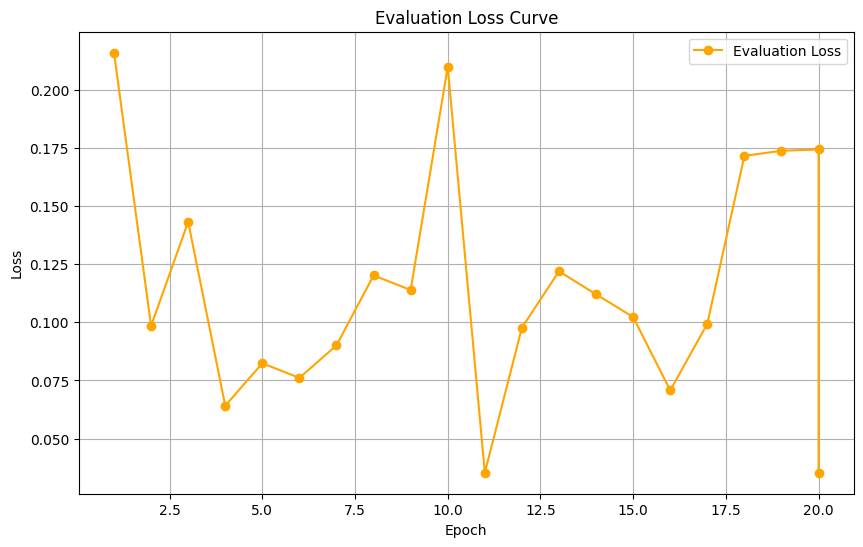

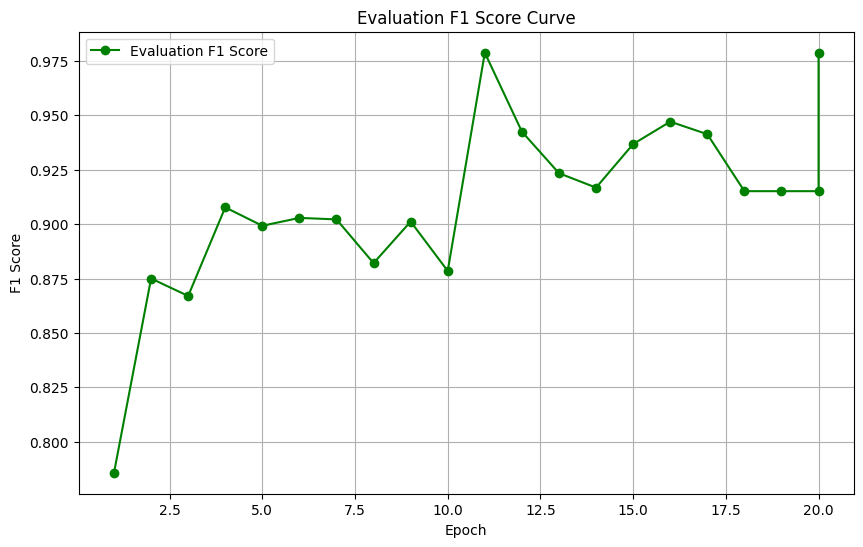

In [37]:
import matplotlib.pyplot as plt

# Plot Training Loss Curve
if 'train_loss' in log_df.columns:
    train_logs = log_df[log_df["epoch"].notnull() & log_df["train_loss"].notnull()]
    plt.figure(figsize=(10, 6))
    plt.plot(train_logs["epoch"], train_logs["train_loss"], label="Training Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No training loss data available.")

# Plot Evaluation Loss Curve
if 'eval_loss' in log_df.columns:
    eval_logs = log_df[log_df["epoch"].notnull() & log_df["eval_loss"].notnull()]
    plt.figure(figsize=(10, 6))
    plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="Evaluation Loss", color="orange", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Evaluation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No evaluation loss data available.")

# Plot F1 Score Curve
if 'eval_f1' in log_df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(eval_logs["epoch"], eval_logs["eval_f1"], label="Evaluation F1 Score", color="green", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Evaluation F1 Score Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No F1 score data available.")


In [38]:
 eval_logs["eval_f1"]

,eval_f1
0,0.785781
1,0.875000
2,0.866986
3,0.907677
4,0.899225
5,0.902846
6,0.902153
7,0.882071
8,0.901163
9,0.878469
